<a href="https://colab.research.google.com/github/aasr-1001/TFOD/blob/main/Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-14-2ff8dda173dc>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=undervalued_neighborhoods.head(10), x='Neighborhood', y='Undervaluation', palette="coolwarm")


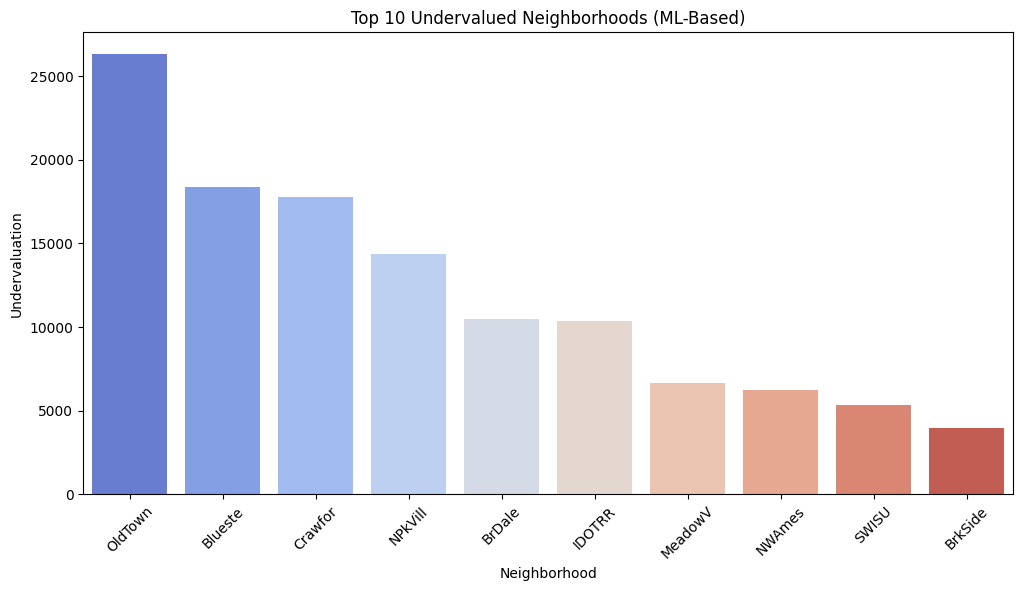

R2 score: 0.72


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df = pd.read_csv("train_processed.csv")

neighborhood_columns = [col for col in df.columns if col.startswith("Neighborhood_")]
neighborhood_names = [col.replace("Neighborhood_", "") for col in neighborhood_columns]

df_filtered = df[neighborhood_columns + ['SalePrice', 'OverallQual', 'OverallCond']].copy()
#QualityScore is the average of OverallQual and OverallCond
df_filtered.loc[:, 'QualityScore'] = (df_filtered['OverallQual'] + df_filtered['OverallCond']) / 2


df_filtered['Neighborhood'] = df_filtered[neighborhood_columns].idxmax(axis=1).str.replace("Neighborhood_", "")


neighborhood_stats = df_filtered.groupby('Neighborhood').agg(
    AvgPrice=('SalePrice', 'mean'),
    AvgQuality=('QualityScore', 'mean')
).reset_index()


X = neighborhood_stats[['Neighborhood', 'AvgQuality']]
y = neighborhood_stats['AvgPrice']

X_encoded = pd.get_dummies(X, columns=['Neighborhood'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
#predict avg price based on quality + neighborhood
neighborhood_stats['ExpectedPrice'] = model.predict(pd.get_dummies(X, columns=['Neighborhood']))

neighborhood_stats['Undervaluation'] = neighborhood_stats['ExpectedPrice'] - neighborhood_stats['AvgPrice']

undervalued_neighborhoods = neighborhood_stats.sort_values(by="Undervaluation", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=undervalued_neighborhoods.head(10), x='Neighborhood', y='Undervaluation', palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Undervalued Neighborhoods (ML-Based)")
plt.xlabel("Neighborhood")
plt.ylabel("Undervaluation")
plt.show()

# Evaluate model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.2f}")


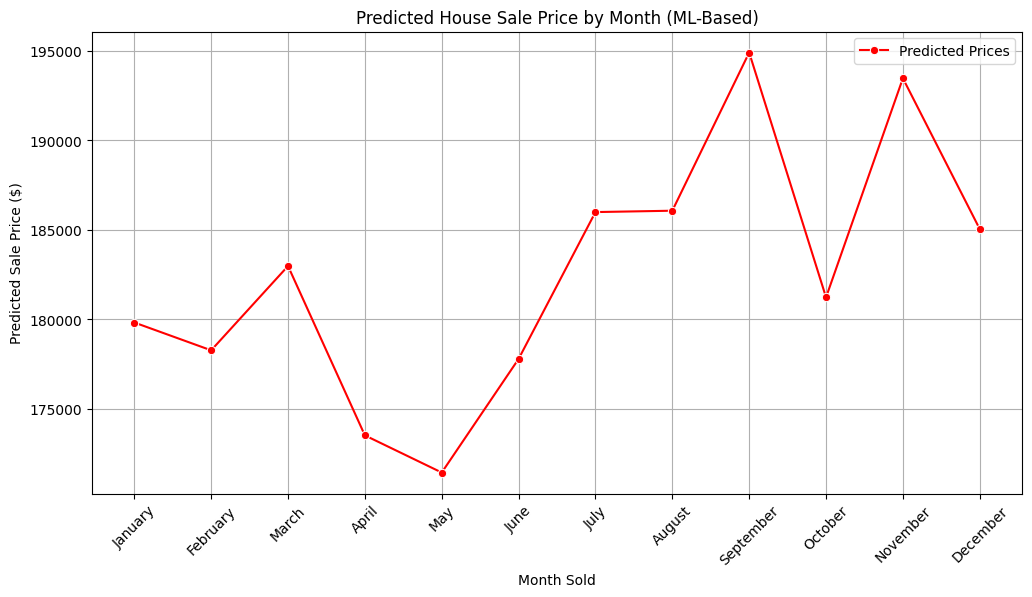

📈 Best Month to Sell (ML Prediction): September
📉 Best Month to Buy (ML Prediction): May
📊 Model R² Score: 0.8718


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

df = pd.read_csv("train_processed.csv")

df['Month'] = df['MoSold'].apply(lambda x: calendar.month_name[x])


df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['Price_per_sqft'] = df['SalePrice'] / df['GrLivArea']


features = ['Month', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageCars', 'HouseAge']
X = df[features]
y = df['SalePrice']

preprocessor = ColumnTransformer([
    ('month', OneHotEncoder(handle_unknown='ignore'), ['Month']),
    ('scaler', StandardScaler(), ['OverallQual', 'OverallCond', 'GrLivArea', 'GarageCars', 'HouseAge'])
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

df['PredictedPrice'] = model.predict(X)


monthly_avg_prices = df.groupby("Month")["PredictedPrice"].mean()


ordered_months = list(calendar.month_name[1:])  # ['January', 'February', ..., 'December']
monthly_avg_prices = monthly_avg_prices.reindex(ordered_months)


best_month_to_sell = monthly_avg_prices.idxmax()
worst_month_to_buy = monthly_avg_prices.idxmin()


plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_avg_prices.index, y=monthly_avg_prices.values, marker="o", color="r", label="Predicted Prices")
plt.xticks(rotation=45)
plt.title("Predicted House Sale Price by Month (ML-Based)")
plt.xlabel("Month Sold")
plt.ylabel("Predicted Sale Price ($)")
plt.legend()
plt.grid()
plt.show()


print(f"Best Month to Sell (ML Prediction): {best_month_to_sell}")
print(f"Best Month to Buy (ML Prediction): {worst_month_to_buy}")
print(f"Model R² Score: {r2:.4f}")


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("train_processed.csv")
scaler = StandardScaler()
df["LotArea"] = scaler.fit_transform(df[["LotArea"]])

df["GreenEnergyScore"] = (
    df.filter(like="HeatingQC_").sum(axis=1) * 2 +   # Heating quality
    df.filter(like="CentralAir_").sum(axis=1) * 2 +  # Central air
    df["LotArea"] * 1.5 +   # Lot size
    df.filter(like="ExterQual_").sum(axis=1) * 1.5 + # Exterior quality
    df.filter(like="BsmtExposure_").sum(axis=1) * 1 + # Basement exposure
    df.filter(like="RoofStyle_").sum(axis=1) * 1 +    # Roof style
    df.filter(like="RoofMatl_").sum(axis=1) * 1 +     # Roof material
    df.filter(like="LotConfig_").sum(axis=1) * 1 +    # Lot configuration
    df.filter(like="Street_").sum(axis=1) * 1 +       # Street type
    df.filter(like="Electrical_").sum(axis=1) * 1 +   # Electrical system
    df.filter(like="PavedDrive_").sum(axis=1) * 0.5   # Paved driveway
)

X = df[["LotArea"] + df.filter(like="HeatingQC_").columns.tolist() + df.filter(like="CentralAir_").columns.tolist() + df.filter(like="ExterQual_").columns.tolist() + df.filter(like="BsmtExposure_").columns.tolist() + df.filter(like="RoofStyle_").columns.tolist() + df.filter(like="RoofMatl_").columns.tolist() + df.filter(like="LotConfig_").columns.tolist() + df.filter(like="Street_").columns.tolist() + df.filter(like="Electrical_").columns.tolist() + df.filter(like="PavedDrive_").columns.tolist()]
y = df["GreenEnergyScore"]

threshold = df["GreenEnergyScore"].quantile(0.75)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

def predict_green_energy(lot_area, features):
    # Normalize LotArea
    lot_area_scaled = scaler.transform([[lot_area]])[0][0]
    input_data = pd.DataFrame({
        "LotArea": [lot_area_scaled],
        **{col: [0] for col in df.filter(like="HeatingQC_").columns},
        **{col: [0] for col in df.filter(like="CentralAir_").columns},
        **{col: [0] for col in df.filter(like="ExterQual_").columns},
        **{col: [0] for col in df.filter(like="BsmtExposure_").columns},
        **{col: [0] for col in df.filter(like="RoofStyle_").columns},
        **{col: [0] for col in df.filter(like="RoofMatl_").columns},
        **{col: [0] for col in df.filter(like="LotConfig_").columns},
        **{col: [0] for col in df.filter(like="Street_").columns},
        **{col: [0] for col in df.filter(like="Electrical_").columns},
        **{col: [0] for col in df.filter(like="PavedDrive_").columns}
    })

    for feature in features:
        if feature in input_data:
            input_data[feature] = 1

    prediction = clf.predict(input_data)[0]
    is_green_house = "Green House" if prediction >= threshold else "Not a Green House"
    percentile = (df["GreenEnergyScore"] < prediction).mean() * 100
    return prediction, is_green_house, percentile

def get_user_input():
    lot_area = float(input("Enter Lot Area: "))
    features = input("Enter features separated by commas (if any, else leave blank): ").split(',')

    features = [feature.strip() for feature in features if feature.strip()]
    result, classification, percentile = predict_green_energy(lot_area, features)
    print("Predicted Green Energy Score:", result)
    print(f"This house belongs to the top {100 - percentile:.2f}% most energy-efficient houses.")
y_pred = clf.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print results
print("RandomForest Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score (Accuracy-like): {r2 * 100:.2f}%")
if __name__ == "__main__":
    get_user_input()

RandomForest Model Evaluation:
Mean Absolute Error (MAE): 0.01
Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.12
R² Score (Accuracy-like): 98.08%
Enter Lot Area: 8796
Enter features separated by commas (if any, else leave blank): HeatingQC, RoofMatl_Shngl
Predicted Green Energy Score: 11.74187243458474
This house belongs to the top 59.93% most energy-efficient houses.


In [32]:
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=UserWarning)

# Load data
df = pd.read_csv("train_processed.csv")

# Scale LotArea
scaler = StandardScaler()
df["LotArea"] = scaler.fit_transform(df[["LotArea"]])

# Calculate HomeExpansionScore for entire dataset
df["HomeExpansionScore"] = (
    df["LotArea"] * 2 +
    df.filter(like="LotShape_").sum(axis=1) * 1.5 +
    df.filter(like="MSZoning_").sum(axis=1) * 1
)

# Calculate median of scores
median_score = df["HomeExpansionScore"].median()

# Prediction function without model
def predict_expansion(lot_area, lot_shape_features, mszoning_features):
    lot_area_scaled = scaler.transform([[lot_area]])[0][0]

    input_data = pd.DataFrame({
        "LotArea": [lot_area_scaled],
        **{col: [0] for col in df.filter(like="LotShape_").columns},
        **{col: [0] for col in df.filter(like="MSZoning_").columns}
    })

    for feature in lot_shape_features:
        if feature in input_data:
            input_data[feature] = 1
    for feature in mszoning_features:
        if feature in input_data:
            input_data[feature] = 1

    # Compute score
    score = (
        input_data["LotArea"].iloc[0] * 2 +
        input_data.filter(like="LotShape_").sum(axis=1).iloc[0] * 1.5 +
        input_data.filter(like="MSZoning_").sum(axis=1).iloc[0] * 1
    )

    return "Can be expanded" if score > median_score else "Cannot be expanded"

# Interactive user input
def get_user_input():
    lot_area = float(input("Enter Lot Area: "))
    lot_shape_features = input("Enter LotShape features separated by commas (if any, else leave blank): ").split(',')
    mszoning_features = input("Enter MSZoning features separated by commas (if any, else leave blank): ").split(',')

    lot_shape_features = [f"LotShape_{feature.strip()}" for feature in lot_shape_features if feature.strip()]
    mszoning_features = [f"MSZoning_{feature.strip()}" for feature in mszoning_features if feature.strip()]

    result = predict_expansion(lot_area, lot_shape_features, mszoning_features)
    print("Prediction:", result)

if __name__ == "__main__":
    get_user_input()


Enter Lot Area: 6785
Enter LotShape features separated by commas (if any, else leave blank): HeatingQC,MSZoning_RL
Enter MSZoning features separated by commas (if any, else leave blank): RH
Prediction: Cannot be expanded


In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("train_processed.csv")

# Extract relevant columns
neighborhood_cols = [col for col in df.columns if col.startswith("Neighborhood_")]
house_style_cols = [col for col in df.columns if col.startswith("HouseStyle_")]
building_type_cols = [col for col in df.columns if col.startswith("BldgType_")]
neighborhood_names = [col.replace("Neighborhood_", "") for col in neighborhood_cols]
house_styles = [col.replace("HouseStyle_", "") for col in house_style_cols]
building_types = [col.replace("BldgType_", "") for col in building_type_cols]

# Create quality score feature
df["QualityScore"] = (df["OverallQual"] + df["OverallCond"]) / 2

# Prepare data
features = df.drop(columns=["SalePrice"])
target = df["SalePrice"]

# Train model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Recommendation Function
def recommend_house(user_neighborhood, user_budget, user_house_type, min_size):
    neighborhood_col = f"Neighborhood_{user_neighborhood}"
    house_type_col = f"HouseStyle_{user_house_type}"
    building_type_col = f"BldgType_{user_building_type}"

    # Validations
    if neighborhood_col not in df.columns:
        return f"Neighborhood '{user_neighborhood}' not found in the dataset."
    if house_type_col not in df.columns:
        return f"House type '{user_house_type}' not found in the dataset."
    if building_type_col not in df.columns:
        return f"Building type '{user_building_type}' not found in the dataset."
    # Filter based on preferences
    filtered = df[
        (df[neighborhood_col] == 1) &
        (df[house_type_col] == 1) &
        (df[building_type_col] == 1) &
        (df["GrLivArea"] >= min_size) &
        (df["SalePrice"] <= user_budget)
    ].copy()

    if filtered.empty:
        return "No houses match your preferences within the budget."

    # Predict prices and sort
    filtered["PredictedPrice"] = model.predict(filtered.drop(columns=["SalePrice"]))
    recommended = filtered.sort_values(by=["QualityScore", "PredictedPrice"], ascending=[False, True]).iloc[0]

    return {
        "Neighborhood": user_neighborhood,
        "Budget": user_budget,
        "Preferred House Type": user_house_type,
        "Building Type": user_building_type,
        "Min Size (GrLivArea)": min_size,
        "Recommended House": recommended.to_dict()
    }

# 🏡 User Input Interface
print("Available Neighborhoods:")
print(", ".join(neighborhood_names))

print("\nAvailable House Types:")
print(", ".join(house_styles))

user_neighborhood = input("\nEnter the neighborhood name (e.g., CollgCr): ").strip()
user_house_type = input("Enter your preferred house type (e.g., 1Story, 2Story): ").strip()
user_building_type = input("Enter your preferred building type (e.g., 1Fam, TwnhsE): ").strip()
try:
    user_budget = int(input("Enter your maximum budget: "))
    min_size = int(input("Enter minimum required house size (GrLivArea in sq ft): "))
except ValueError:
    print("Please enter valid numeric values.")
else:
    result = recommend_house(user_neighborhood, user_budget, user_house_type, min_size)
    print("\nRecommendation Result:")
    print(result)


Available Neighborhoods:
Blmngtn, Blueste, BrDale, BrkSide, ClearCr, CollgCr, Crawfor, Edwards, Gilbert, IDOTRR, MeadowV, Mitchel, NAmes, NPkVill, NWAmes, NoRidge, NridgHt, OldTown, SWISU, Sawyer, SawyerW, Somerst, StoneBr, Timber, Veenker

Available House Types:
1.5Fin, 1.5Unf, 1Story, 2.5Fin, 2.5Unf, 2Story, SFoyer, SLvl

Enter the neighborhood name (e.g., CollgCr): Crawfor
Enter your preferred house type (e.g., 1Story, 2Story): 2Story
Enter your preferred building type (e.g., 1Fam, TwnhsE): 1Fam
Enter your maximum budget: 140000
Enter minimum required house size (GrLivArea in sq ft): 1600

Recommendation Result:
{'Neighborhood': 'Crawfor', 'Budget': 140000, 'Preferred House Type': '2Story', 'Building Type': '1Fam', 'Min Size (GrLivArea)': 1600, 'Recommended House': {'MSSubClass': 70.0, 'LotFrontage': 60.0, 'LotArea': 9550.0, 'OverallQual': 7.0, 'OverallCond': 5.0, 'YearBuilt': 1915.0, 'YearRemodAdd': 1970.0, 'MasVnrArea': 0.0, 'BsmtFinSF1': 216.0, 'BsmtFinSF2': 0.0, 'BsmtUnfSF': 540